In [1]:
import numpy as np
import xarray as xr
import yaml
from pathlib import Path
from kalman_reconstruction.custom_plot import (
    set_custom_rcParams,
    adjust_lightness,
    plot_colors,
    symmetrize_axis,
    handler_map_alpha,
    symmetrize_axis,
    plot_state_with_probability,
)
# from reconstruct_climate_indices.idealized_ocean import sponge_ocean, oscillatory_ocean
from reconstruct_climate_indices.statistics import linear_regression_loglog
from kalman_reconstruction.pipeline import from_standard_dataset, add_random_variable, xarray_Kalman_SEM, all_choords_as_dim
from kalman_reconstruction.statistics import normalize, crosscorr
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
# from sklearn.linear_model import LinearRegression
from scipy import signal

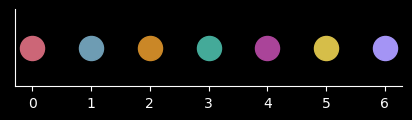

In [2]:
# ## LIGHT THEME
# plt.style.use("seaborn-v0_8-whitegrid")
# dark_color = [0.3, 0.3, 0.3]
# light_color = [0.8, 0.8, 0.8]
# lightness_0 = 0.75
# lightness_1 = 0.5
# cmap = "rocket"
# cmap_r = "rocket_r"

### DARK THEME
plt.style.use("dark_background")
dark_color = [0.7, 0.7, 0.7]
light_color = [0.2, 0.2, 0.2]
lightness_0 = 1.15
lightness_1 = 1.5
cmap = "rocket_r"
cmap_r = "rocket"


colors = set_custom_rcParams()
plt.rcParams["axes.grid"] = False

plot_colors(colors)

variables_color = dict()
variables_color["SAT"] = colors[0]
variables_color["SST"] = colors[2]
variables_color["DOT"] = colors[1]
variables_color["latent"] = colors[3]
variables_color["loglikelihood"] = (colors[-1],)

In [17]:
REPO_PATH = Path(".").resolve().parent
results_path = REPO_PATH / Path("results") / "Presentation" / "Example_Idealized_Oceans_150y"
results_path.mkdir(parents=True, exist_ok=True)
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

In [52]:
df = 0.115
tau0 = 10  # years
per0 = 12  # years
lambda0 = 2 / tau0  / (2 * np.pi) # years
omega0 = 2 * np.pi/per0  / (2 * np.pi)# years 

# NOTE: 
# The PSD units for the SAT are originally given in K^{2} d^{-1} y^{-1} but this is uglly
# So it is better to multuply the SAT by np.sqrt(1/365.25) to get it in K y^{-0.5} 
SAT_factor = np.sqrt(1/365.25) # factor by which the input to the fft function should be multiplied to get the units mentioned above
SAT_PSD_units = r"$K^2 y^{-2}$" 
SST_DOT_PSD_units = r"$K^2 y^{-1}$" 

print(rf"$\lambda_0$ = {lambda0}")
print(rf"$\omega_0$ = {omega0}")


SAT_units = r"$K d^{-0.5}$" 
SST_DOT_units = r"$K$" 

# NOTE: 
# The PSD units for the SAT are originally given in K^{2} d^{-1} y^{-1} but this is uglly
# So it is better to multuply the SAT by np.sqrt(1/365.25) to get it in K y^{-0.5} 
SAT_factor = np.sqrt(1/365.25) # factor by which the input to the fft function should be multiplied to get the units mentioned above
SAT_PSD_units = r"$K^2 y^{-2}$" 
SST_DOT_PSD_units = r"$K^2 y^{-1}$" 

$\lambda_0$ = 0.03183098861837907
$\omega_0$ = 0.08333333333333333


In [53]:
# # For 1000y data for all kalman_iteration
# SubdataPath = "simplified_ocean_experiments"
# sponge_run_name = "efficient-shrew-653"
# oscillatory_run_name = "sincere-frog-475" 

# For 150y data for all tau0, per0
SubdataPath = "Evaluation-Idealized-Ocean"
sponge_run_name = "flawless-loon-25"
oscillatory_run_name = "dapper-fox-131" 
seed = 331381460666

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    seed = seed,
    # df=df,
)

oscillatory_select_dict = dict(
    per0=per0 * 365.25,
    tau0=tau0 * 365.25,
    seed = seed,
    # seed=331381460666,
)

In [54]:
# Sponge ocean
run_name = sponge_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    sponge_settings = yaml.safe_load(stream)
select_dict = sponge_select_dict

sponge_data = experiments.sel(select_dict)
sponge_kalman_states = experiments_kalman_states.sel(select_dict) #.sel(kalman_iteration = 29)
# sponge_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )

In [55]:
# Oscillatory ocean
run_name = oscillatory_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    oscillatory_settings = yaml.safe_load(stream)
select_dict = oscillatory_select_dict


oscillatory_data = experiments.sel(select_dict)
oscillatory_kalman_states = experiments_kalman_states.sel(select_dict) #.sel(kalman_iteration = 29)
# oscillatory_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )

#### 1. Evolution of both states:

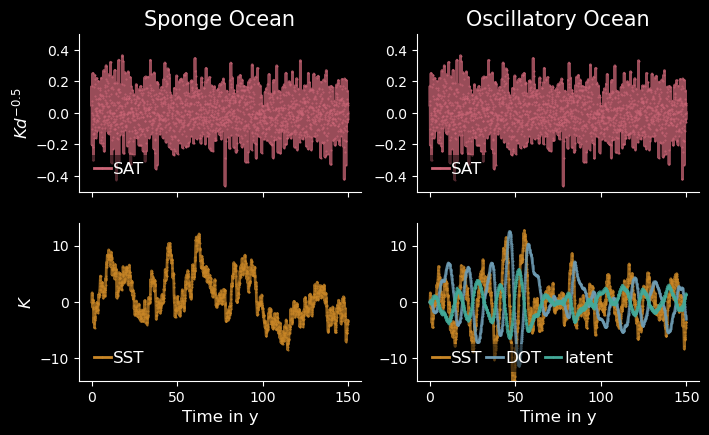

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
kwargs = dict(
    linestyle="-",
    linewidth="2",
    marker=".",
    markersize = 1,
    alpha = 0.75
)

axs_sponge = axs[:, 0]
axs_oscill = axs[:, 1]
axs_sponge[0].set_title("Sponge Ocean")
axs_oscill[0].set_title("Oscillatory Ocean")

factor = 3 
total_length = 12*150
return_lines = False

time_slice = slice(0*factor, 0*factor + total_length)



# -------------------
# Plot SPONGE OCEAN
# -------------------
# Plot SAT
var = "SAT"
line_sponge_SAT, = axs_sponge[0].plot(
    sponge_data["time_years"].isel(time = time_slice),
    sponge_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)
# Plot SST
var = "SST"
line_sponge_SST, = axs_sponge[1].plot(
    sponge_data["time_years"].isel(time = time_slice),
    sponge_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)
# -------------------
# Plot Oscillatory OCEAN
# -------------------
var = "SAT"
line_oscillatory_SAT, =  axs_oscill[0].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)
# SST 
var = "SST"
line_oscillatory_SST, = axs_oscill[1].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)
var = "DOT"
line_oscillatory_DOT, = axs_oscill[1].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)

# var = "latent"
# line_oscillatory_DOT, = axs_oscill[1].plot(
#     oscillatory_kalman_states["time_years"].isel(time = time_slice),
#     oscillatory_kalman_states[var].isel(time = time_slice),
#     label=var,
#     color=variables_color[var],
#     **kwargs,
# )

# Label and lims for SAT 
axs_sponge[0].set_ylabel(f"{SAT_units}")
# axs_oscill[0].set_ylabel(f"{SAT_units}")
axs_oscill[0].set_ylim([-0.5, 0.5])
axs_sponge[0].set_ylim([-0.5, 0.5])

# Label and lims for SAT 
axs_sponge[1].set_ylabel(f"{SST_DOT_units}")
# axs_oscill[1].set_ylabel(f"{SST_DOT_units}")
axs_oscill[1].set_ylim([-14, 14])
axs_sponge[1].set_ylim([-14, 14])

# set xlabel
axs_oscill[1].set_xlabel("Time in y")
axs_sponge[1].set_xlabel("Time in y")

for ax in axs.flatten() :
    ax.legend(
        ncols=3, 
        loc = "lower left",
        handlelength = 1,
        handletextpad=0.15,
        columnspacing=0.2,
        handler_map = handler_map_alpha()
        )
    # ax.set_xlim(xmin= sponge_data.time_years.isel(time = time_slice)[0],
    #             xmax = sponge_data.time_years.isel(time = time_slice)[-1])


def init(
        idx, 
        factor = 6, 
        total_length = 12*50,
        ):
    pass

def update_lines(
        idx, 
        sponge, 
        oscillator, 
        factor = factor, 
        total_length = total_length,
        ):
    time_slice = slice(idx*factor, idx*factor + total_length)
    sponge_data = sponge.isel(time = time_slice)
    oscillatory_data = oscillator.isel(time = time_slice)
    x_lims = sponge.time_years.isel(time = time_slice)

    for var, line in [
        ["SAT", line_sponge_SAT],
        ["SST", line_sponge_SST], 
    ]:
        line.set_ydata(sponge_data[var])
        line.set_xdata(sponge_data.time_years)
    for var, line in [
        ["SAT", line_oscillatory_SAT],
        ["SST", line_oscillatory_SST], 
        ["DOT", line_oscillatory_DOT]
    ]:
        line.set_ydata(oscillatory_data[var])
        line.set_xdata(oscillatory_data.time_years)
    
    # for ax in axs.flatten():
    #     ax.set_xlim(xmin= x_lims[0],
    #                 xmax = x_lims[-1])
    return line_sponge_SAT, line_sponge_SST, line_oscillatory_SAT, line_oscillatory_SST, line_oscillatory_DOT


# save_fig(fig, relative_path=f"Evolution_states_latent_tau0_{tau0}_per0_{per0}.svg")
# save_fig(fig, relative_path=f"Evolution_states_latent_tau0_{tau0}_per0_{per0}.png", dpi = 256)
# ani = animation.FuncAnimation(
#     fig, update_lines, interval=50, blit=True, save_count=1000, fargs = [sponge_data, oscillatory_data])
# from IPython.display import HTML
# HTML(ani.to_html5_video())
# ani

In [62]:
# # # To save the animation using Pillow as a gif
writer = animation.FFMpegWriter(
    fps=24,
    metadata=dict(artist='Me'),
    bitrate=-1,
)
ani.save(results_path / f'Example_state_evolution_tau0{tau0}_per0{omega0}.mp4', writer=writer, dpi = 256)
# with open("myvideo.html", "w") as f:
#     print(ani.to_html5_video(), file=f)